<a href="https://colab.research.google.com/github/captain-pool/hub/blob/add_ESRGAN_colab/tf2_hub_single_image_super_resolution_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the \"License\");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

### Image Super Resolution using ESRGAN
TensorFlow implementation of Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)].

Model trained on DIV2K Dataset on image patches of size 128 x 128

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

**Preparing Environment**

In [2]:
!pip3 install -U scipy==0.19

     |████████████████████████████████| 48.2MB 49.4MB/s 
ERROR: yellowbrick 0.9.1 has requirement scipy>=1.0.0, but you'll have scipy 0.19.0 which is incompatible.
ERROR: plotnine 0.5.1 has requirement scipy>=1.0.0, but you'll have scipy 0.19.0 which is incompatible.
ERROR: mir-eval 0.5 has requirement scipy>=1.0.0, but you'll have scipy 0.19.0 which is incompatible.
ERROR: librosa 0.6.3 has requirement scipy>=1.0.0, but you'll have scipy 0.19.0 which is incompatible.
ERROR: cvxpy 1.0.24 has requirement scipy>=1.1.0, but you'll have scipy 0.19.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
import os
import time
from PIL import Image
from scipy import misc
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
tf.enable_v2_behavior()
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [4]:
!wget "http://v3wall.com/wallpaper/1920_1200/1412/1920_1200_20141203080119557960.jpg" -O original.jpg

--2019-08-19 09:31:57--  http://v3wall.com/wallpaper/1920_1200/1412/1920_1200_20141203080119557960.jpg
Resolving v3wall.com (v3wall.com)... 67.229.138.10
Connecting to v3wall.com (v3wall.com)|67.229.138.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517101 (505K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>] 504.98K  1.19MB/s    in 0.4s    

2019-08-19 09:31:58 (1.19 MB/s) - ‘original.jpg’ saved [517101/517101]



In [0]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz"

In [0]:
def preprocess_image(image_path):
  """
      Loads image from path and scales down using bicubic downsampling.
      Args:
          image_path: Path to the image file.
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  _can_calculate_psnr = False
  if hr_image.shape[0] >= 720 and hr_image.shape[1] >= 1080:
      hr_image = tf.image.random_crop(hr_image, [720, 1080, 3])
      _can_calculate_psnr = True
  lr_image = tf.expand_dims(misc.imresize(hr_image, [720 // 4, 1080 // 4], interp="bicubic"), 0)
  lr_image = tf.cast(lr_image, tf.float32)
  hr_image = tf.cast(hr_image, tf.float32)
  return lr_image, hr_image, _can_calculate_psnr

In [0]:
% matplotlib inline
def plot_image(image, title="", save=False):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  if not image.dtype is tf.uint8:
    image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  if save:
    image.save("%s.jpg" % title)
    print("Saved Image to: %s.jpg" % title)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)
  plt.show()

In [14]:
lr_image, hr_image, _can_calculate_psnr = preprocess_image(IMAGE_PATH)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


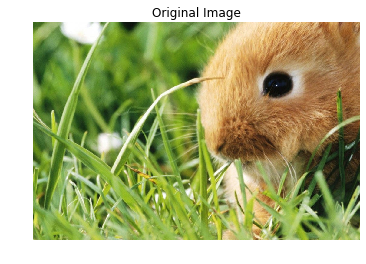

In [15]:
# Plotting Original Resolution image
plot_image(hr_image, title="Original Image")

In [0]:
model = hub.load(SAVED_MODEL_PATH)

In [17]:
start = time.time()
fake_image = model.call(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 12.496090


Saved Image to: Low Resolution.jpg


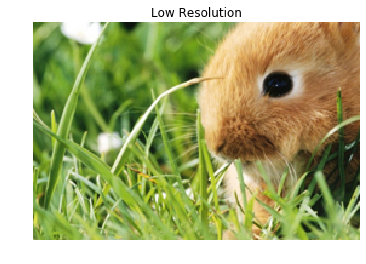

In [18]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), "Low Resolution", save=True)

Saved Image to: Super Resolution.jpg


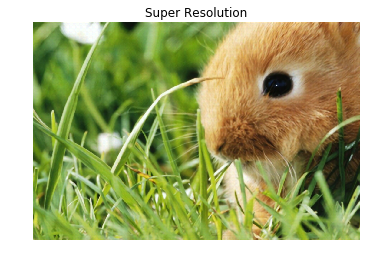

PSNR Achieved: 32.681866


In [19]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), "Super Resolution", save=True)
# Calculating PSNR wrt Original Image
if _can_calculate_psnr:
  print("PSNR Achieved: %f" % tf.image.psnr(
      tf.clip_by_value(fake_image, 0, 255),
      tf.clip_by_value(hr_image, 0, 255), max_val=255))